In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

# linear Koopman
from core.koopman_core_linear import KoopDNN as KoopDNN
from core.koopman_core_linear import KoopmanNet as KoopmanNet
from core.koopman_core_linear import KoopmanNetCtrl as KoopmanNetCtrl
from core.adapt_net_lin import AdaptNet_lin

from core.utility import Output_Con


from models.koop_model import model_matricies,lift

# data generation
from dynamics.robot_3R import dynamics_3R_data_gen, dynamics_3R
from dynamics.Vanpol import dynamics_vanpol




## import paths for controllability
from paths.paths import path_pars
import control as ct

## OSQP terms
import osqp
import numpy as np
import scipy as sp
from scipy import sparse


In [4]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

In [5]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.1

In [6]:
X_end,X_full, U_full = dynamics_3R_data_gen(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


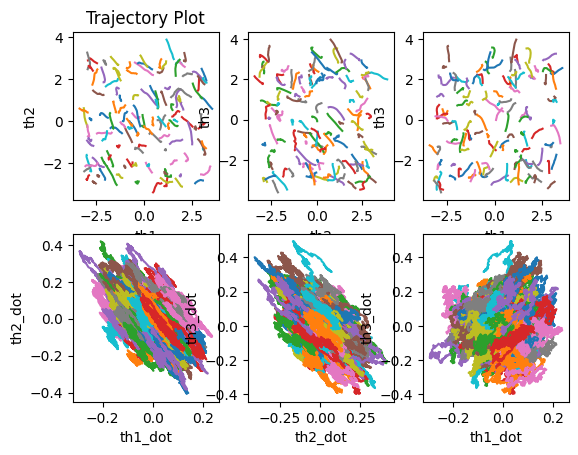

In [7]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])



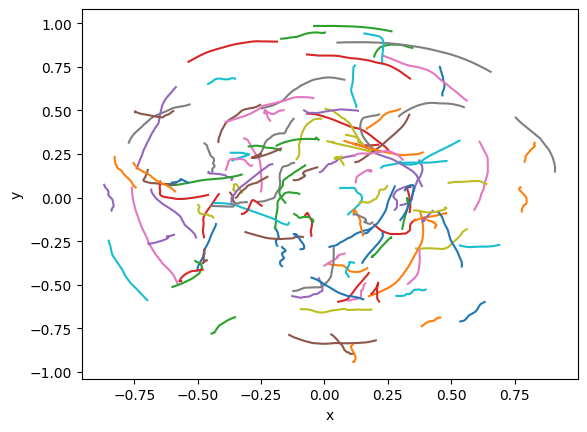

In [8]:
#x and y positions of the end effector

plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

In [9]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [10]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 10
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 4e-4 # 5e-4
net_params['epochs'] = 2000
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [11]:
train = False

if train == True:
    file = 'saved_models/learned_models/linear_model/robot_3r_lin.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/learned_models/linear_model/robot_3r_lin.pth'
    model_koop_dnn = torch.load(file)

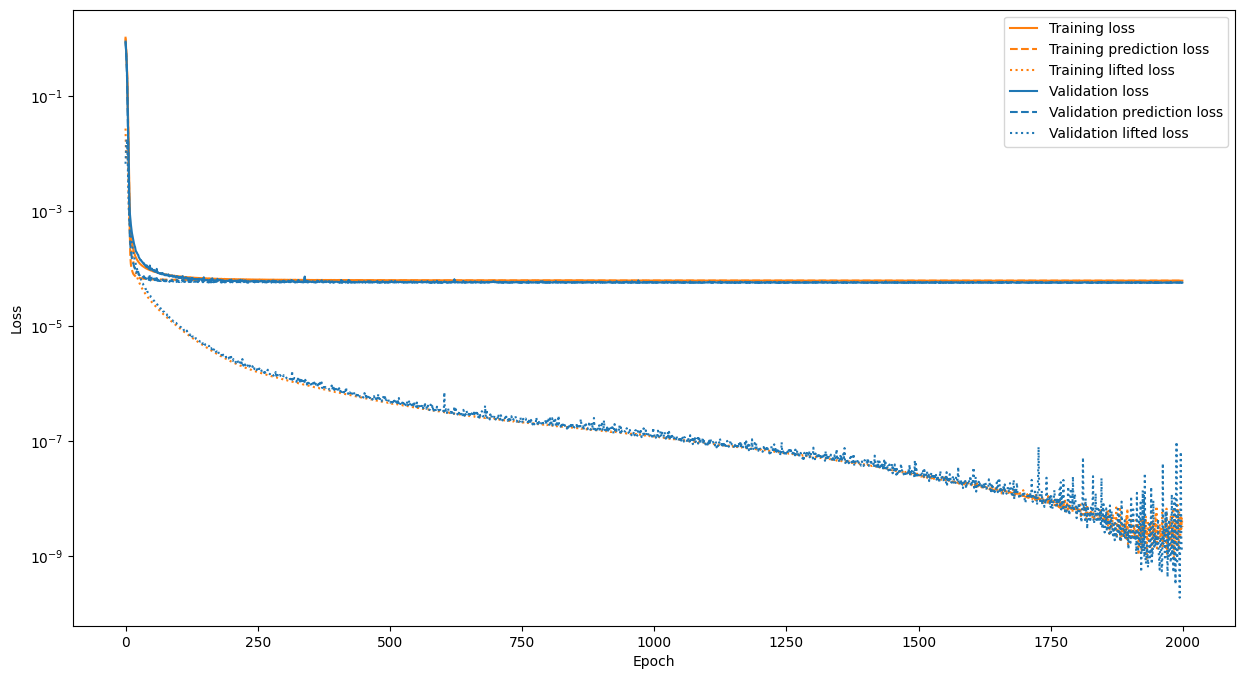

In [12]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Linear Model

In [13]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 3) (6, 17)


## Controllability

In [14]:
#check controllability
Con_lin = ct.ctrb(A, B)
rank_lin = np.linalg.matrix_rank(Con_lin)

print(rank_lin)

14


## Output Controllability

In [15]:
out_con_mat, out_con_rank = Output_Con(A,B,C)


print(out_con_mat.shape)
print(out_con_rank)

(6, 54)
6


## Testing

In [16]:
# test data parameters
num_snaps_val = 2000 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

In [18]:
xs_end_test,xs_test, us_test = dynamics_3R_data_gen(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)
print(model_koop_dnn.test_loss(xs_test,u_test = us_test))

tensor(4.6724e-05)


In [19]:
X,_ = model_koop_dnn.net.process(xs_test,data_u = us_test)
print(X.shape)

(2000, 15)


In [20]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


In [21]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T

z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

## Time Evolution

In [22]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)   

## Joint Space Evolution

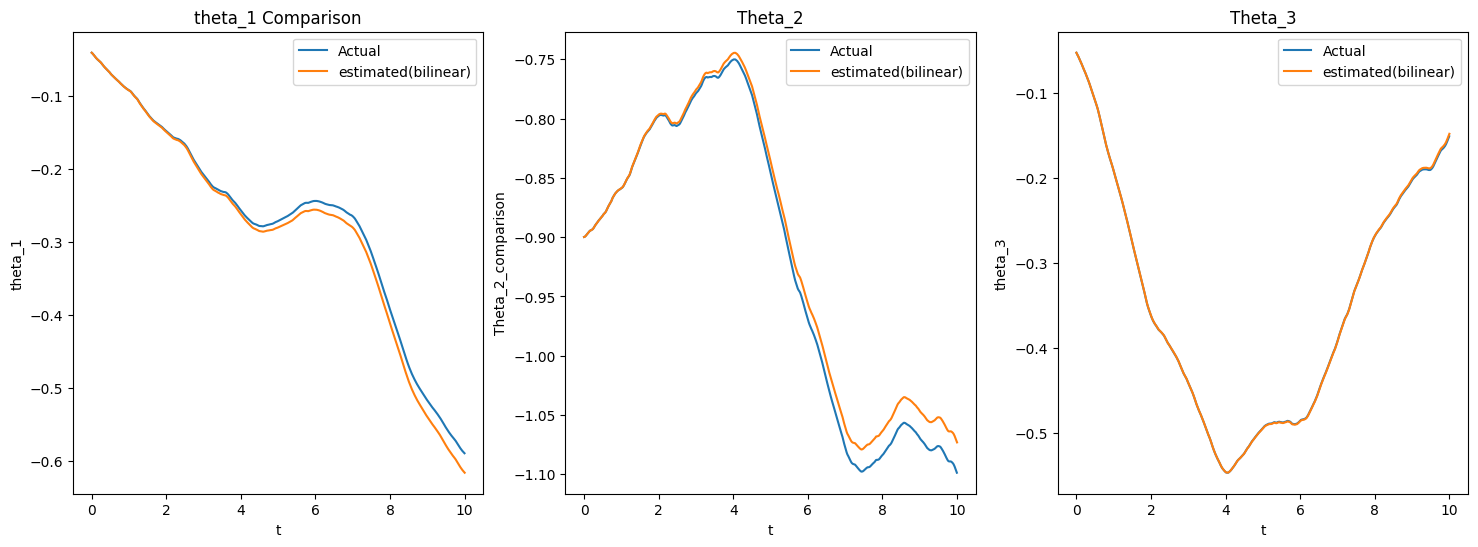

In [23]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

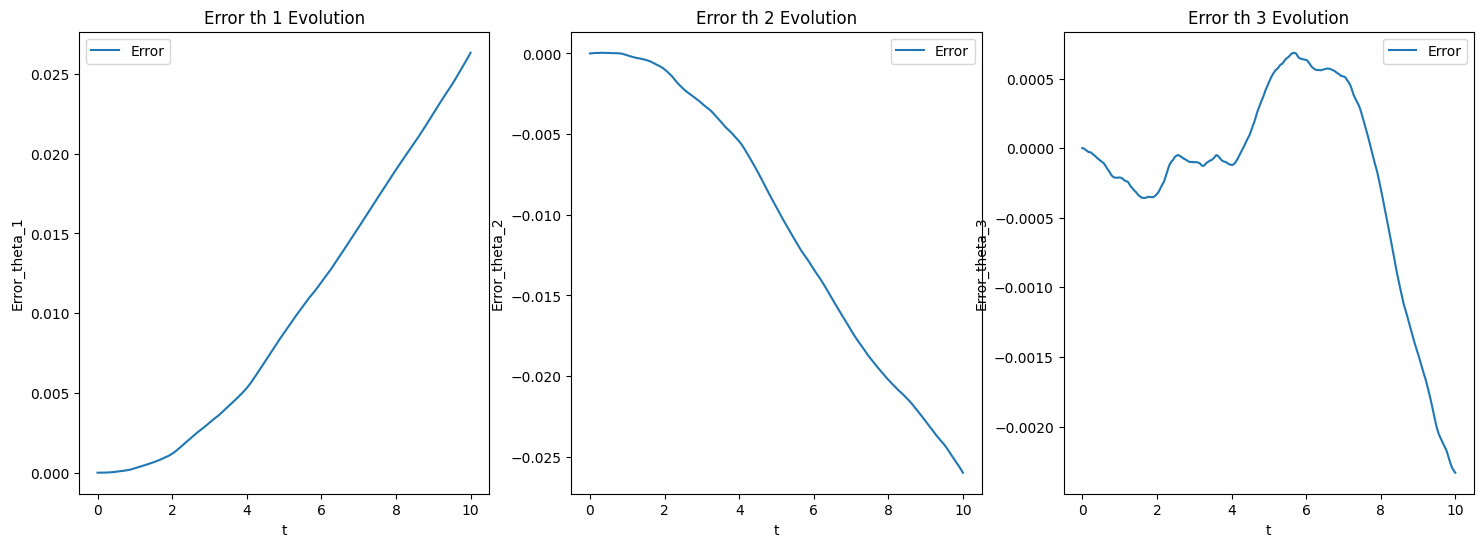

In [24]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T[:-1],x[:,0] - x_est[:-1,0],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_1')
plt.title('Error th 1 Evolution')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T[:-1],x[:,1] - x_est[:-1,1],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_2')
plt.title('Error th 2 Evolution')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T[:-1],x[:,2] - x_est[:-1,2],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_3')
plt.title('Error th 3 Evolution')
plt.legend()

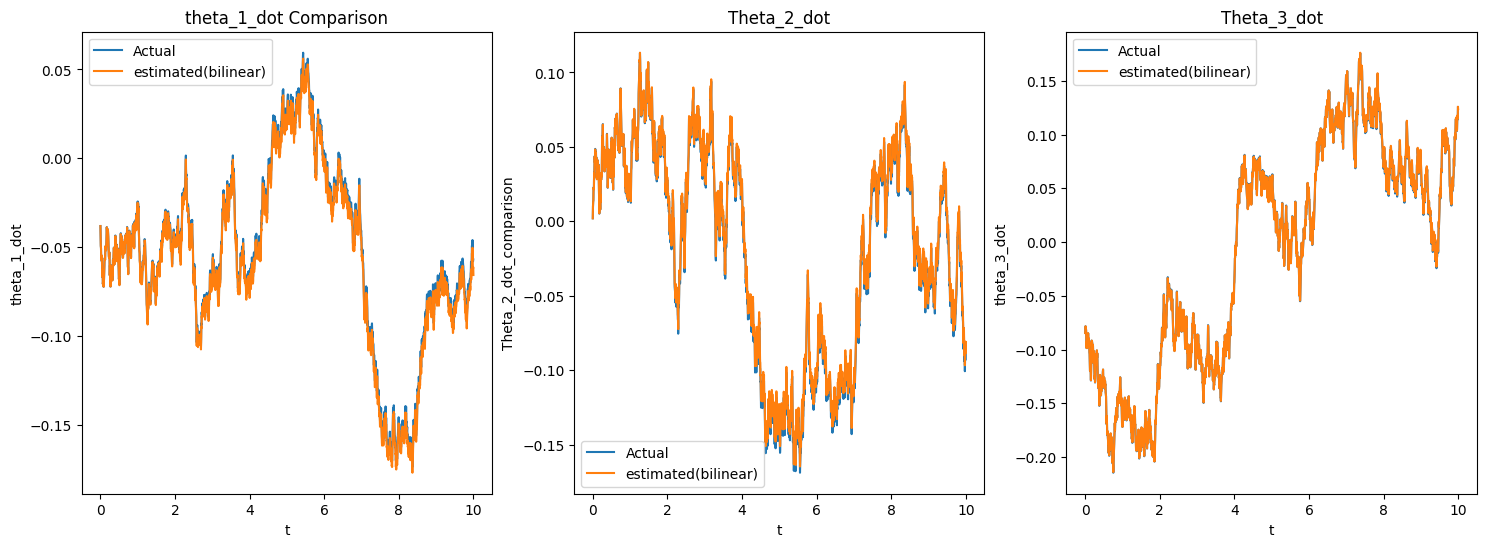

In [25]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('Theta_2_dot_comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()


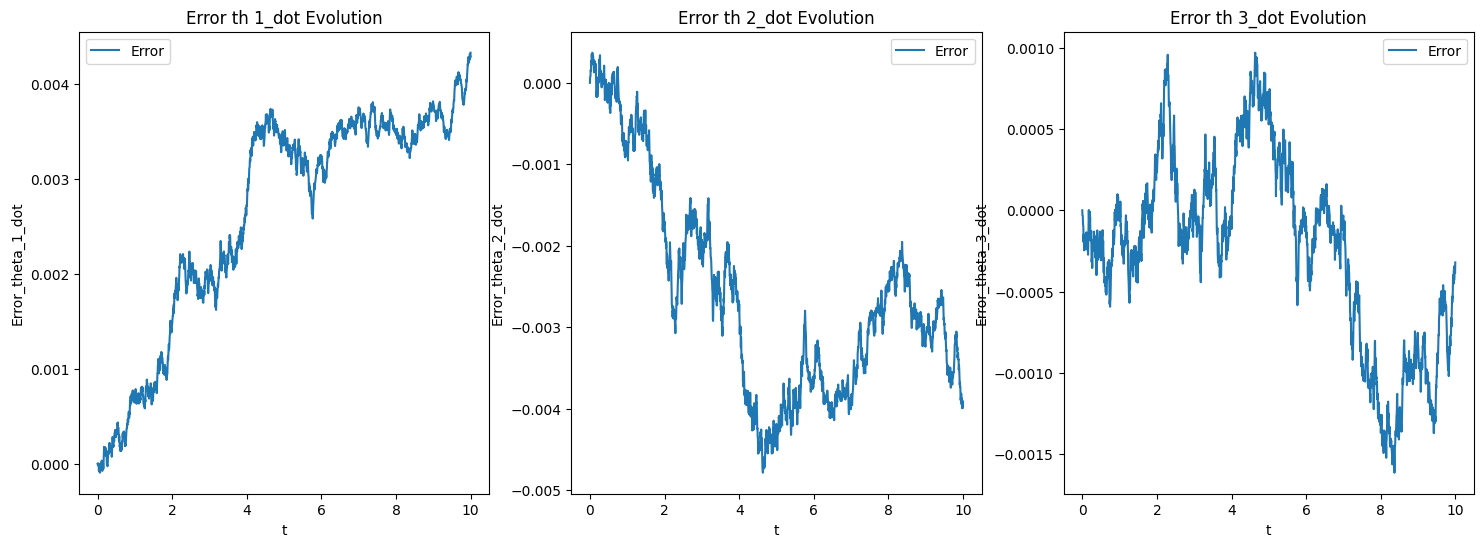

In [26]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(T[:-1],x[:,3] - x_est[:-1,3],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_1_dot')
plt.title('Error th 1_dot Evolution')
plt.legend()

plt.subplot(1,3,2)
plt.plot(T[:-1],x[:,4] - x_est[:-1,4],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_2_dot')
plt.title('Error th 2_dot Evolution')
plt.legend()

plt.subplot(1,3,3)
plt.plot(T[:-1],x[:,5] - x_est[:-1,5],label ='Error')
plt.xlabel('t')
plt.ylabel('Error_theta_3_dot')
plt.title('Error th 3_dot Evolution')
plt.legend()

## Controllers

## Reference Trajectory

In [27]:
t_ctrl = np.arange(start=0, stop=10, step=dt)
num_snaps_ctrl = t_ctrl.shape[0]

In [28]:
## linear path
x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

In [29]:
x_ref.shape

(3, 2000)

In [30]:
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C

## ZNN

In [31]:
gamma = 50

In [32]:
## specify the matricies
z_ctrl = np.empty((n_obs,num_snaps_ctrl))
x_ctrl = np.empty((num_states,num_snaps_ctrl))
u_ctrl = np.empty((num_inputs,num_snaps_ctrl-1))

## initialize the matricies
x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)

In [34]:
x_ref_full = np.vstack((x_ref,x_ref_dot))
x_ref_dot_full = np.vstack((x_ref_dot,x_ref_ddot))
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(C,Bc)), -np.matmul(C,np.matmul(Ac,z_ctrl[:,i])) + x_ref_dot_full[:,i] - gamma*(x_ctrl[:,i] - x_ref_full[:,i]))
                    
    x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

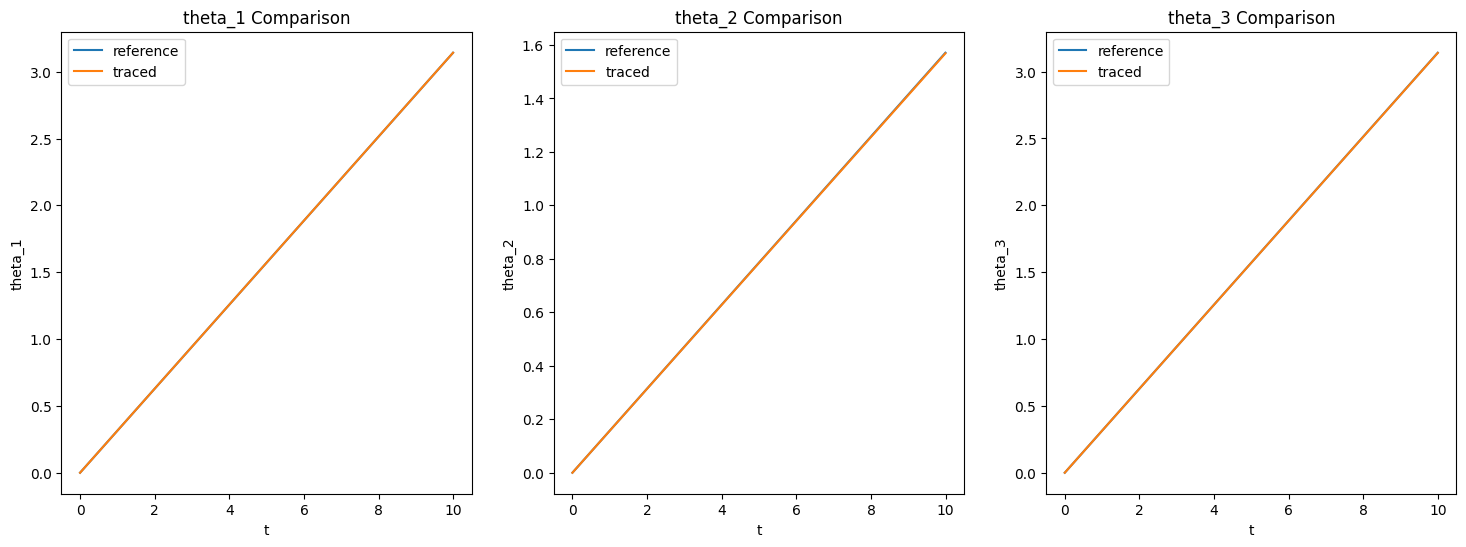

In [35]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref[0,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[0,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref[1,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[1,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2 Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_ctrl[:],x_ref[2,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[2,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.title('theta_3 Comparison')
plt.legend()

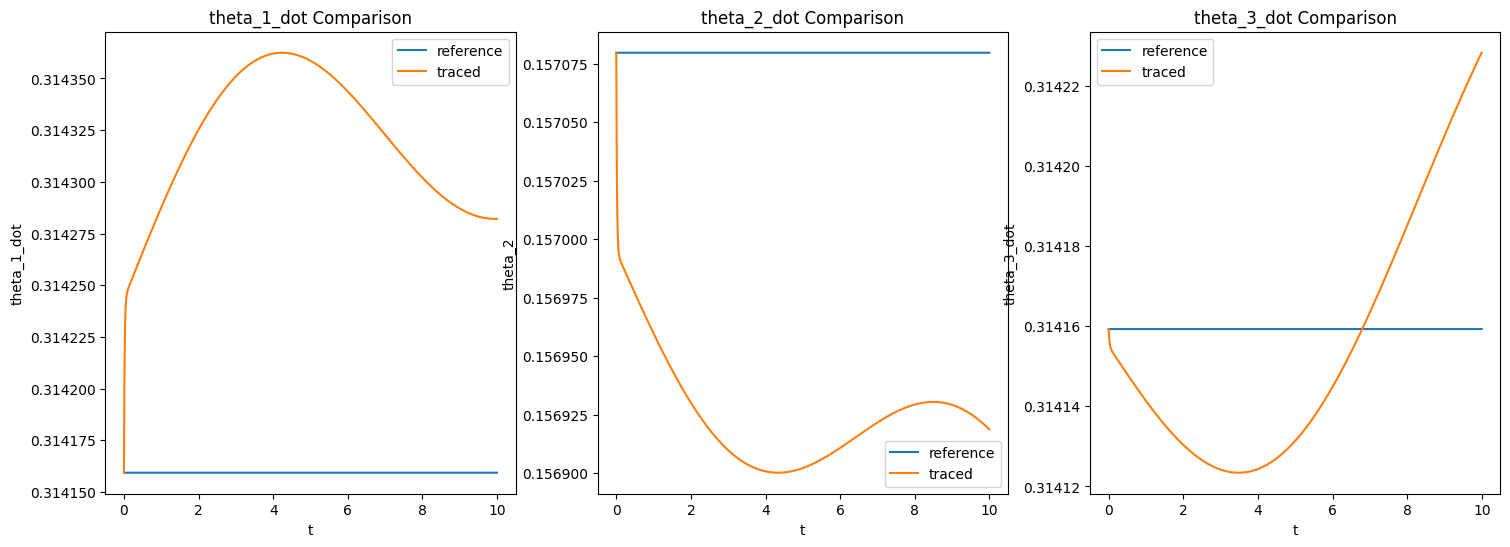

In [36]:
plt.figure(figsize=(18, 6)) 

plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref_dot[0,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[3,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref_dot[1,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[4,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2_dot Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_ctrl[:],x_ref_dot[2,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[5,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.title('theta_3_dot Comparison')
plt.legend()


Text(0.5, 1.0, 'theta_3_ddot Comparison')

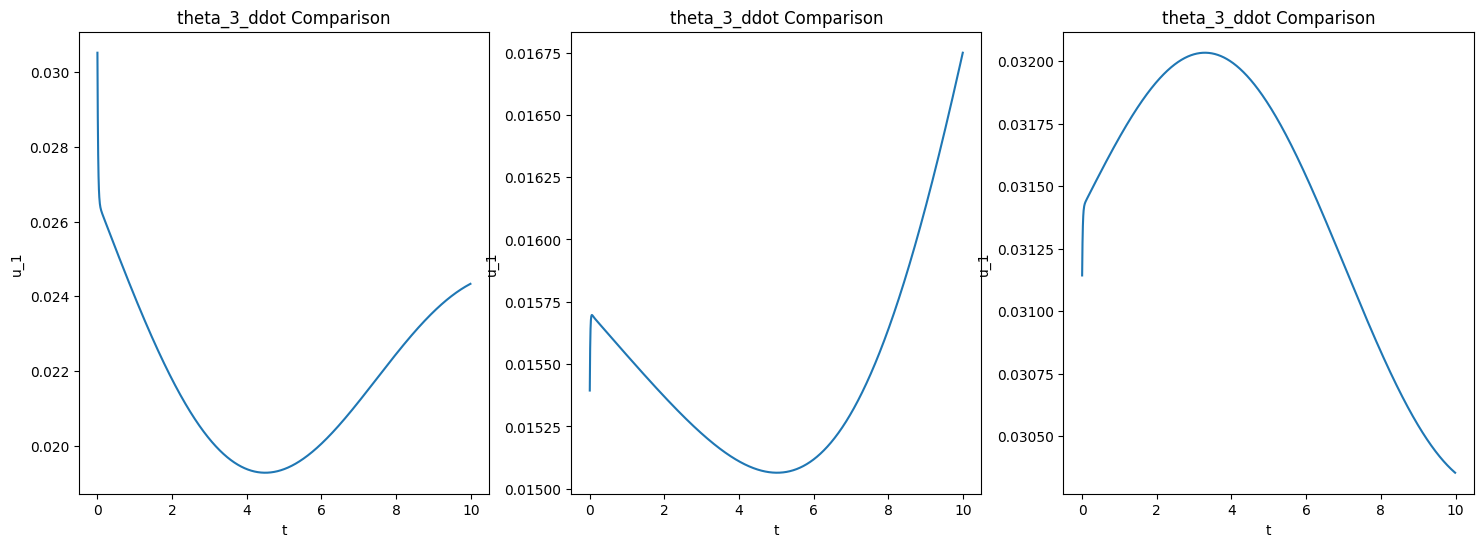

In [37]:
plt.figure(figsize=(18, 6)) 

plt.subplot(1,3,1)
plt.plot(t_ctrl[:-1],u_ctrl[0,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')

plt.subplot(1,3,2)
plt.plot(t_ctrl[:-1],u_ctrl[1,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')

plt.subplot(1,3,3)
plt.plot(t_ctrl[:-1],u_ctrl[2,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')

## MPC

In [38]:
## specify the matricies
z_mpc = np.empty((n_obs,num_snaps_ctrl))
x_mpc = np.empty((num_states,num_snaps_ctrl))
u_mpc = np.empty((num_inputs,num_snaps_ctrl-1))

## initialize the matricies
x_mpc[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
z_mpc[:,0] = lift(x_mpc[:,0],model_koop_dnn, net_params)

In [39]:
Ad = sparse.csc_matrix(A)
Bd = sparse.csc_matrix(B)
[nx, nu] = Bd.shape

In [40]:
nx, nu

(17, 3)

In [41]:
umax = 10*np.array([1, 1, 1])
umin = -10*np.array([1, 1, 1])

xmax =  10*np.ones(n_obs)
xmin = -10*np.ones(n_obs)

In [42]:
Q = 10*sparse.eye(n_obs)
QN = Q
R = 1*sparse.eye(num_inputs)

In [43]:
## Prediction Horizon
N = 20
x0 = z_mpc[:,0]
xr = lift(x_ref_full[:,0],model_koop_dnn, net_params)

P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                       sparse.kron(sparse.eye(N), R)], format='csc')
# - linear objective
q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),
               np.zeros(N*nu)])
# - linear dynamics
Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
Aeq = sparse.hstack([Ax, Bu])
leq = np.hstack([-x0, np.zeros(N*nx)])
ueq = leq
# - input and state constraints
Aineq = sparse.eye((N+1)*nx + N*nu)
lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])
# - OSQP constraints
A_mpc = sparse.vstack([Aeq, Aineq], format='csc')
l = np.hstack([leq, lineq])
u = np.hstack([ueq, uineq])


In [44]:
## Problem Setup
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 40
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'



In [45]:
# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace
prob.setup(P = P, q =q, A =A_mpc, l = l, u = u, verbose=False,
                        warm_start=solver_settings['warm_start'],
                        polish=solver_settings['polish'],
                        polish_refine_iter=solver_settings['polish_refine_iter'],
                        check_termination=solver_settings['check_termination'],
                        eps_abs=solver_settings['eps_abs'],
                        eps_rel=solver_settings['eps_rel'],
                        eps_prim_inf=solver_settings['eps_prim_inf'],
                        eps_dual_inf=solver_settings['eps_dual_inf'],
                        linsys_solver=solver_settings['linsys_solver'],
                        adaptive_rho=solver_settings['adaptive_rho'])

In [47]:
for i in range(num_snaps_ctrl-1):
    
    # Solve
    res = prob.solve();

    # Check solver status
    if res.info.status != 'solved':
        raise ValueError('OSQP did not solve the problem!')

    # Apply first control input to the plant
    u_mpc[:,i] = res.x[-N*nu:-(N-1)*nu]
    x_mpc[0:3,i+1],x_mpc[3:,i+1] = dynamics_3R(dt, u_mpc[:,i], x_mpc[0:3,i],x_mpc[3:,i], robot_pars)
    z_mpc[:,i+1] = lift(x_mpc[:,i+1],model_koop_dnn, net_params)

    x0 = z_mpc[:,i+1]
    # Update initial state
    l[:nx] = -x0
    u[:nx] = -x0
    
    
    xr = lift(x_ref_full[:,0],model_koop_dnn, net_params)
    # - linear objective
    q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),
               np.zeros(N*nu)])
    
    prob.update(q= q, l = l,u = u)

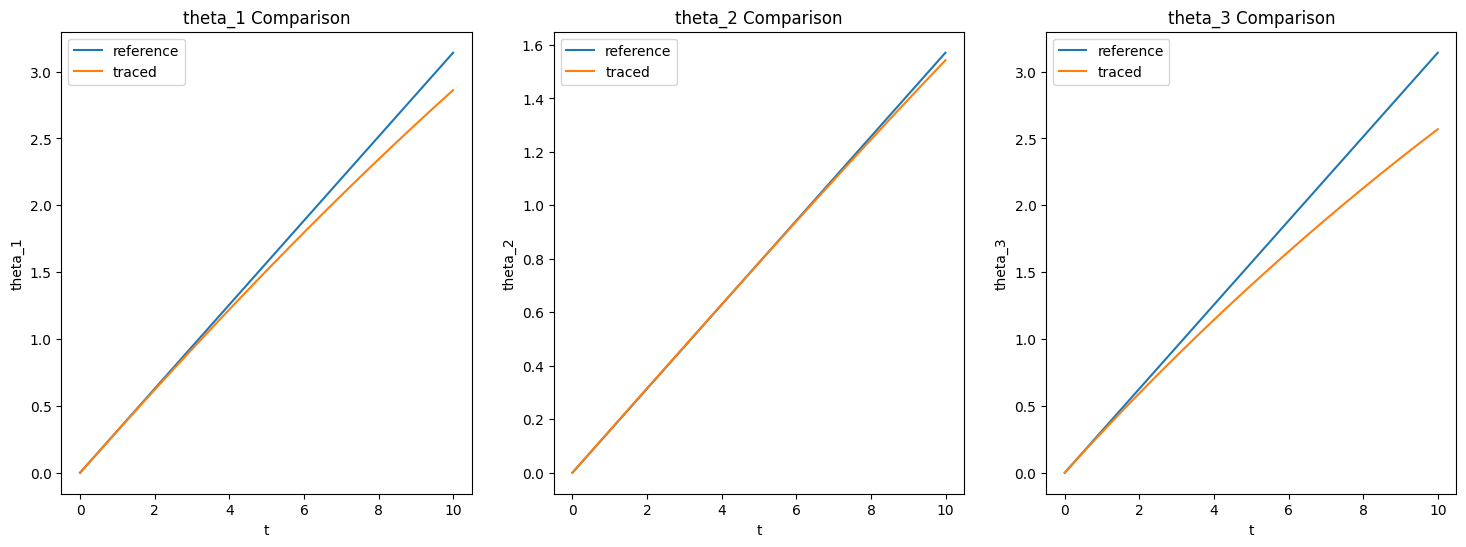

In [48]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref[0,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[0,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref[1,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[1,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2 Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_ctrl[:],x_ref[2,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[2,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.title('theta_3 Comparison')
plt.legend()

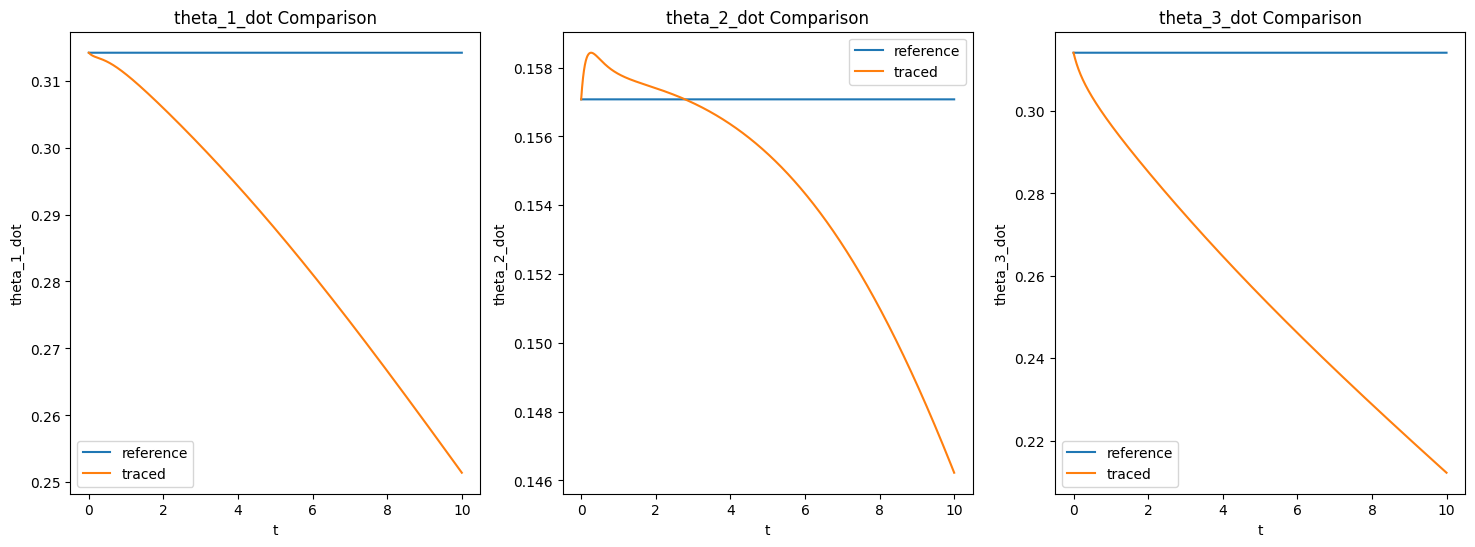

In [49]:
plt.figure(figsize=(18, 6)) 

plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref_dot[0,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[3,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref_dot[1,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[4,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.title('theta_2_dot Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_ctrl[:],x_ref_dot[2,:],label ='reference')
plt.plot(t_ctrl[:],x_mpc[5,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.title('theta_3_dot Comparison')
plt.legend()


Text(0.5, 1.0, 'theta_3_ddot Comparison')

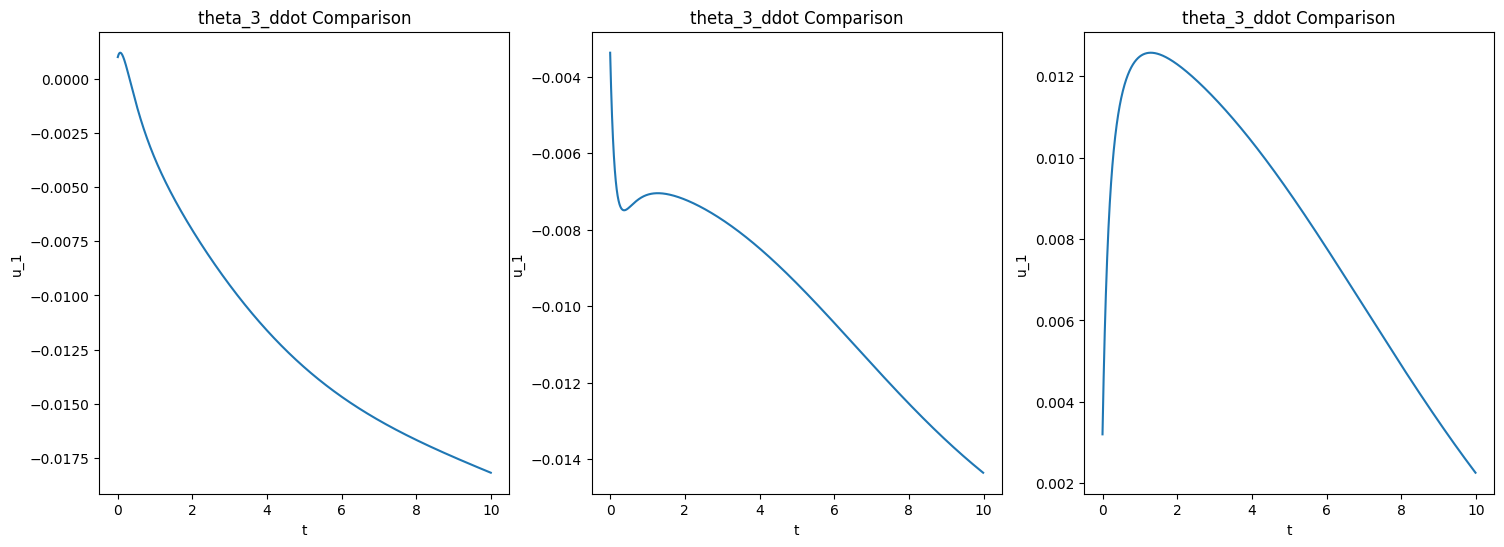

In [50]:
plt.figure(figsize=(18, 6)) 

plt.subplot(1,3,1)
plt.plot(t_ctrl[:-1],u_mpc[0,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')

plt.subplot(1,3,2)
plt.plot(t_ctrl[:-1],u_mpc[1,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')

plt.subplot(1,3,3)
plt.plot(t_ctrl[:-1],u_mpc[2,:])
plt.xlabel('t')
plt.ylabel('u_1')
plt.title('theta_3_ddot Comparison')